In [ ]:
!pip install tensorflow==2.17.1
!pip install matplotlib==3.9.2

print("==== All required libraries are installed =====")

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data Preparation

In [3]:
input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Hola.", "¿Cómo estás?", "Estoy aprendiendo traducción automática.", "¿Cuál es tu nombre?", "Me encanta programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

In [4]:
# Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [5]:
max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [7]:
decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

# Self-Attention Layer

In [8]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='glorot_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

# Model Architecture

In [9]:
# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Attention Mechanism
attention_layer = SelfAttention()(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

# Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 256)    │      4,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 5, 256)    │      4,352 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 5, 256),  │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 5, 256),  │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_1    │ (None, 5, 256)    │    196,608 │ lstm_1[0][0]      │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 17)     │      4,369 │ self_attention_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,260,049 (4.81 MB)

 Trainable params: 1,260,049 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [10]:
history_glorot_adam = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0400 - loss: 2.8354
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3200 - loss: 2.7972
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2800 - loss: 2.7538
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2800 - loss: 2.6947
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2800 - loss: 2.6098
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2800 - loss: 2.4923
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2400 - loss: 2.3606
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2400 - loss: 2.3263
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2800 - loss: 2.3642
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2800 - loss: 2.2938
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3200 - loss: 2.2213
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.

# Plotting the training loss

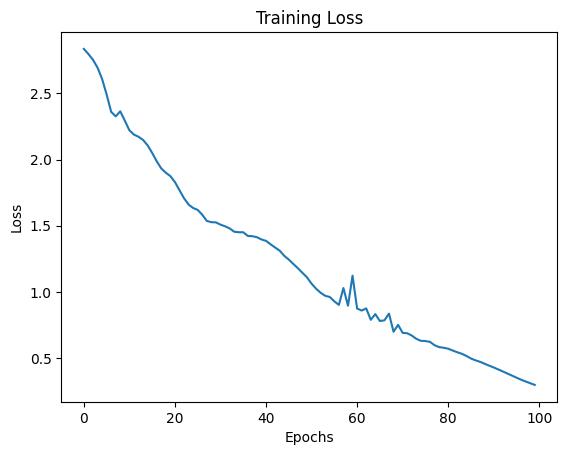

In [11]:
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1200 - loss: 2.8308
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2800 - loss: 2.7863
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.2800 - loss: 2.7355
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2800 - loss: 2.6688
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2800 - loss: 2.5771
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2400 - loss: 2.4565
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2400 - loss: 2.3323
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2400 - loss: 2.3137
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2800 - loss: 2.3116
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3200 - loss: 2.2394
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.3200 - loss: 2.1834
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.

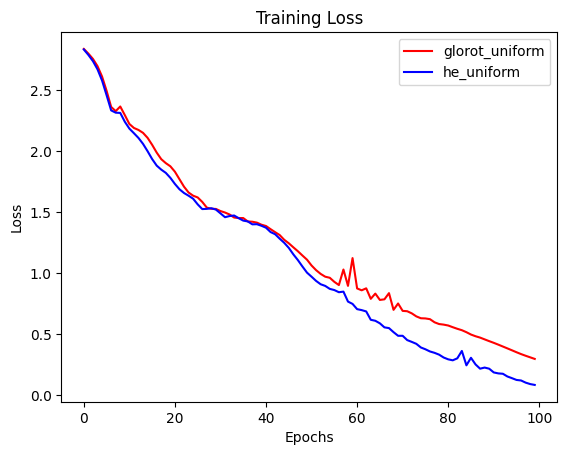

In [12]:
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim), 
                                  initializer='he_uniform', 
                                  trainable=True, 
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    
#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Attention Mechanism
attention_layer = SelfAttention()(encoder_outputs)

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

#Full Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Train the Model
history_he = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - loss: 0.0792
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 1.0000 - loss: 0.0782
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.0774
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0766
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 1.0000 - loss: 0.0759
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 1.0000 - loss: 0.0753
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.0748
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 1.0000 - loss: 0.0743
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 0.0738
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 0.0734
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.0731
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 1.

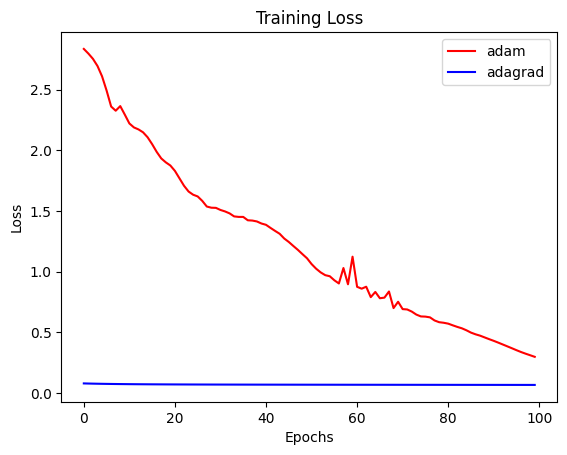

In [13]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

history_adagrad = model.fit([input_sequences, decoder_input_data], decoder_output_data, epochs=100, batch_size=16)

import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="adam", color='red')
plt.plot(history_adagrad.history['loss'], label="adagrad", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()